# Atelier - Introduction à l’apprentissage profond pour la classification des sols

**L’objectif** de cet atelier est de découvrir l'apprentissage profond pour des applications liées à l'observation de la Terre. Il est découpé en trois parties :
1. une introduction à l'apprentissage supervisé et aux réseaux de neurones,
2. une initiation à la bibliothèque d'apprentissage profond [PyTorch](https://pytorch.org/),
3. une mise en application pour la classification des sols à partir d'images satellitaires Sentinel-2.

In [ ]:
!pip install -r requirements.txt

In [1]:
# Import des bibliothèques utiles
import matplotlib.pyplot as plt
import numpy as np
import sklearn

## 1. Apprentissage supervisé et réseaux de neurones

Pour commencer, voyons (ou revoyons) les bases de l'apprentissage supervisé dans le cas d'un problème de classification. Afin de débuter dans un cas simple, on considère le célèbre jeu de données des [Iris de Fisher](https://fr.wikipedia.org/wiki/Iris_de_Fisher). Ce jeu de données contient 50 observations réparties dans trois catégories de fleurs d'iris : *Iris Setosa*, *Iris Virginica* et *Iris versicolor*. Quatre attributs sont mesurés : longueur de sépale, largeur de sépale, longueur de pétale et largeur de pétale. Afin de faciliter les visualisations, nous n'allons conserver que les deux premiers attributs.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
# fixer la graine aléatoire de numpy permet d'obtenir systématiquement les mêmes résultats
np.random.seed(150)

from sklearn import datasets

iris_X, iris_y = datasets.load_iris(return_X_y=True)
data = iris_X[:, :2]
labels = iris_y

Visualisation de toutes les données :

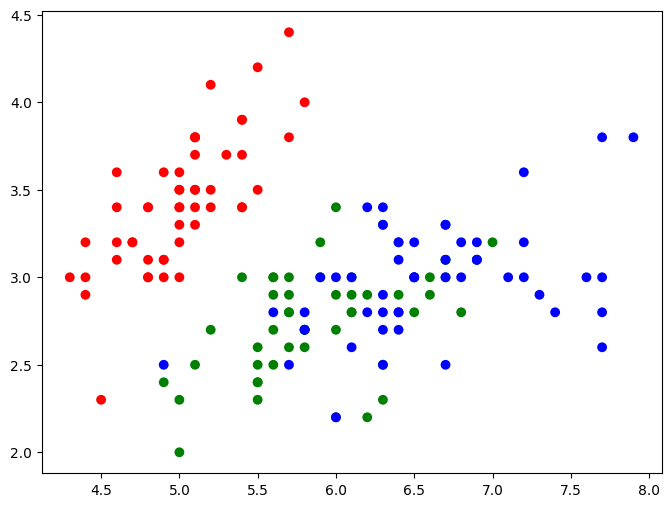

In [3]:
# les échantillons du premier groupe sont en rouge 'r', ceux du deuxième groupe en vert ("green") 'g'
cmp = np.array(['r','g', 'b'])
plt.figure(figsize=(8, 6))
plt.scatter(data[:,0],data[:,1], c=cmp[labels], s=50, edgecolors='none')
plt.show()

Nous générons maintenant un premier découpage entre données d’apprentissage et données de test. Les données de test sont affichées
avec cercles vides (`c='none'`), les données d’apprentissage avec des cercles remplis. Un tiers des données (33%) est conservé pour le test, le reste est utilisé pour l'apprentissage.

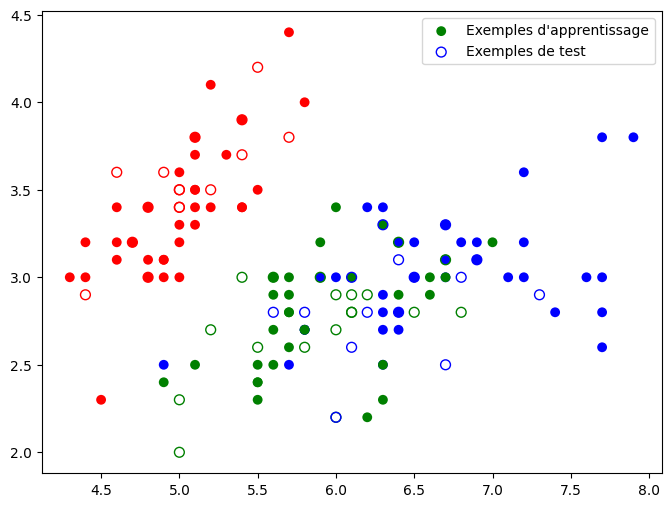

In [4]:
from sklearn.model_selection import train_test_split

# découpage des données en train et test
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.33, random_state=0)

plt.figure(figsize=(8, 6))
plt.scatter(X_train[:,0],X_train[:,1],c=cmp[y_train], s=50, edgecolors='none', label="Exemples d'apprentissage")
plt.scatter(X_test[:,0], X_test[:,1], c='none' ,s=50, edgecolors=cmp[y_test], label="Exemples de test")
plt.legend()
plt.show()

### Modèle non-paramétrique : $k$ plus proches voisins

Considérons pour commencer un classifieur simple pour résoudre cette tâche de discrimination : les $k$ plus proches voisins ou $k$-*nearest neighbors*. Le kNN compare une nouvelle observation aux observations les plus proches (au sens de la distance euclidienne) dans le jeu de données. La classification se fait ensuite par vote majoritaire en fonction des classes auxquelles appartiennent les voisins.

In [5]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)

# évaluation et affichage sur split1
knn.fit(X_train, y_train)
print("Le score sur le jeu d'apprentissage est de : {:.3f}".format(knn.score(X_train, y_train)))

print("Le score sur le jeu de test est de : {:.3f}".format(knn.score(X_test, y_test)))

Le score sur le jeu d'apprentissage est de : 0.810
Le score sur le jeu de test est de : 0.740


Le score renvoyé ici est le taux de bonne classification (*accuracy*).

Nous pouvons examiner visuellement le modèle trouvé en traçant les frontières de décision entre les différentes classes :

In [6]:
from ipywidgets import interact

@interact(n_neighbors=(2, 50, 1))
def knn_fit(n_neighbors=5):
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn.fit(X_train, y_train)
    # on créé une nouvelle figure sur laquelle on affiche les points
    plt.figure(figsize=(8, 6))
    plt.scatter(X_train[:,0], X_train[:,1], c=cmp[y_train], s=50, edgecolors='none', label="Train")
    plt.scatter(X_test[:,0],  X_test[:,1], c='none', s=50, edgecolors=cmp[y_test], label="Test")
    
    # on calcule pour chaque point du plan sa probabilité d'appartenir à chaque classe
    nx, ny = 400, 400
    x_min, x_max = plt.xlim()
    y_min, y_max = plt.ylim()
    # meshgrid permet d'échantillonner tous les points du plan (entre x_min et x_max)
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, nx),np.linspace(y_min, y_max, ny))
    # .predict_proba permet d'obtenir le "score" assigné par le classifieur à chaque point
    Z = knn.predict_proba(np.c_[xx.ravel(), yy.ravel()])
    for cls_idx in range(max(labels)+1):
        zz = Z[:, cls_idx].reshape(xx.shape)
        # on dessine la frontière correspond à un score de 0,5
        # les scores < 0,5 correspondent à la classe 0
        # les scores > 0,5 correspondent à la classe 1
        plt.contour(xx, yy, zz, [0.5])
        plt.contourf(xx, yy, zz, [0.5, 1.0], colors=cmp[cls_idx], alpha=0.5)
    plt.legend()
    plt.show()

interactive(children=(IntSlider(value=5, description='n_neighbors', max=50, min=2), Output()), _dom_classes=('…

Le $k$ plus proche voisin génère des frontières parfois biscornues, notamment lorsque le nombre de voisins considéré est faible. Cette méthode est non-paramétrique, elle est fortement sensible aux changements dans les données et à la présence de données aberrantes (*outlier*).

### Modèle linéaire: SVM

Il est possible de tester un premier modèle paramétrique : la SVM ou machine à vecteur de support. L'idée est de chercher l'hyperplan séparateur (ici, la droite séparatrice) qui maximise la séparation entre les classes prises deux à deux. Autrement dit, on va cherche une frontière de décision linéaire qui a la plus grande « marge » possible. Voyons les frontières de décisions obtenues en pratique :

In [7]:
from sklearn.svm import SVC

import ipywidgets as widgets

@interact(C=widgets.FloatLogSlider(value=1, base=10, min=-5, max=3, step=1))
def svm_fit(C=1.0):
    svm = SVC(C=C, kernel="linear", probability=True)
    
    # évaluation et affichage sur split1
    svm.fit(X_train, y_train)
    print("Le score sur le jeu d'apprentissage est de : {:.3f}".format(svm.score(X_train, y_train)))
    
    print("Le score sur le jeu de test est de : {:.3f}".format(svm.score(X_test, y_test)))
    # on créé une nouvelle figure sur laquelle on affiche les points
    plt.figure(figsize=(8, 6))
    plt.scatter(X_train[:,0], X_train[:,1], c=cmp[y_train], s=50, edgecolors='none', label="Train")
    plt.scatter(X_test[:,0],  X_test[:,1], c='none', s=50, edgecolors=cmp[y_test], label="Test")
    
    # on calcule pour chaque point du plan sa probabilité d'appartenir à chaque classe
    nx, ny = 400, 400
    x_min, x_max = plt.xlim()
    y_min, y_max = plt.ylim()
    # meshgrid permet d'échantillonner tous les points du plan (entre x_min et x_max)
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, nx),np.linspace(y_min, y_max, ny))
    # .decision_function permet d'obtenir le "score" assigné par la SVM à chaque observation
    Z = svm.predict_proba(np.c_[xx.ravel(), yy.ravel()])
    for cls_idx in range(max(labels)+1):
        zz = Z[:, cls_idx].reshape(xx.shape)
        # on dessine la frontière correspond à un score de 0,5
        # les scores < 0,5 correspondent à la classe 0
        # les scores > 0,5 correspondent à la classe 1
        plt.contour(xx, yy, zz, [0.5])
        plt.contourf(xx, yy, zz, [0.5, 1.0], colors=cmp[cls_idx], alpha=0.5)
    plt.legend()
    plt.show()

interactive(children=(FloatLogSlider(value=1.0, description='C', max=3.0, min=-5.0, step=1.0), Output()), _dom…

### Modèle non-linéaire: perceptron multicouche

Comme vous avez pu le constater, la frontière de séparation idéale entre les deux groupes n’est pas linéaire. Il nous faut donc changer de
famille paramétrique pour en choisir une de plus grande capacité. Nous allons donc utiliser un réseau de neurones simple (un perceptron multicouche) pour réaliser la discrimination binaire. Nous utilisons
pour cela la classe [MLPClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier)
de scikit-learn (voir aussi [ces explications](http://scikit-learn.org/stable/modules/neural_networks_supervised.html#classification) concernant le fonctionnement général de cet objet). Il est très
instructif d’examiner [les valeurs par défaut des paramètres](http://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier).

Les trois paramètres importants que nous allons manipuler sont le coefficient d’oubli, le nombre de neurones par couche et le nombre de couches. Par défaut, scikit-learn instancie un réseau de neurones à une
seule couche cachée contenant 100 neurones.

Nous utilisons d’abord un coefficient « d’oubli » (*weight decay*) `alpha = 1e-5`. Ce terme correspond à l’intensité de la régularisation L2 appliquée sur le perceptron. Pour rappel, l’objectif de la
régularisation est de réduire la capacité du modèle.

In [8]:
from sklearn.neural_network import MLPClassifier
# nous utilisons ici l'algorithme L-BFGS pour optimiser le perceptron
clf = MLPClassifier(solver='lbfgs', alpha=1e-5, max_iter=1000, random_state=42)

# évaluation et affichage sur split1
clf.fit(X_train, y_train)
train_score = clf.score(X_train, y_train)
print(f"Le score en train est {train_score:.3f}")

test_score = clf.score(X_test, y_test)
print(f"Le score en test est {test_score:.3f}")

Le score en train est 0.820
Le score en test est 0.800


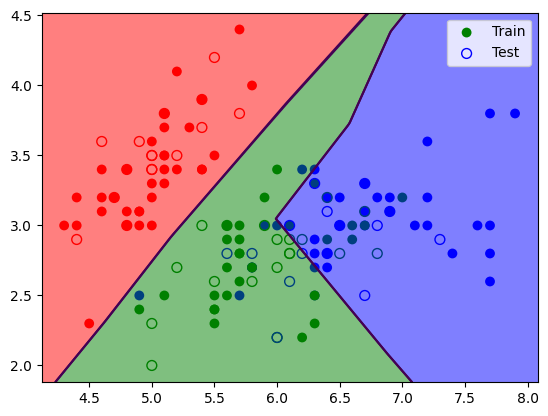

In [9]:
# créer une nouvelle figure
plt.figure()
# afficher les nuages de points apprentissage (remplis) et de test (vides)
plt.scatter(X_train[:,0],X_train[:,1],c=cmp[y_train],s=50, edgecolors='none', label="Train")
plt.scatter(X_test[:,0], X_test[:,1], c='none', s=50, edgecolors=cmp[y_test], label="Test")

# calculer la probabilité de sortie du perceptron pour tous les points du plan
nx, ny = 200, 200
x_min, x_max = plt.xlim()
y_min, y_max = plt.ylim()
xx, yy = np.meshgrid(np.linspace(x_min, x_max, nx),np.linspace(y_min, y_max, ny))
Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])
for cls_idx in range(max(labels)+1):
    zz = Z[:, cls_idx].reshape(xx.shape)
    # on dessine la frontière correspond à un score de 0,5
    # les scores < 0,5 correspondent à la classe 0
    # les scores > 0,5 correspondent à la classe 1
    plt.contour(xx, yy, zz, [0.5])
    plt.contourf(xx, yy, zz, [0.5, 1.0], colors=cmp[cls_idx], alpha=0.5)
plt.legend()
plt.show()

La visualisation interactive ci-dessous permet de manipuler simultanément les trois paramètres importants que nous avons décrit précédemment : coefficient d’oubli, nombre de couches, nombre de
neurones par couche. Dans le perceptron, les paramètres à optimiser sont les poids des connexions entre les neurones. Plus il y a de couches et plus il y a de neurones dans une couche, plus le nombre de connexions est élevé (et par conséquent plus il y a de paramètres).

In [10]:
import ipywidgets as widgets

@interact(alpha=widgets.FloatLogSlider(value=1, base=10, min=-5, max=3, step=1),
          neurons=(10, 200, 10),
          layers=(1, 4, 1))
def mlp_fit(alpha, neurons, layers):
    # nous utilisons ici l'algorithme L-BFGS pour optimiser le perceptron
    layer_sizes = (neurons,) * layers
    clf = MLPClassifier(solver='lbfgs', alpha=alpha, hidden_layer_sizes=layer_sizes, max_iter=1000, tol=1e-3, random_state=0)

    # évaluation et affichage sur split1
    clf.fit(X_train, y_train)
    train_score = clf.score(X_train, y_train)
    print(f"Le score en train est {train_score:.3f}")

    test_score = clf.score(X_test, y_test)
    print(f"Le score en test est {test_score:.3f}")

    # on créé une nouvelle figure sur laquelle on affiche les points
    plt.figure(figsize=(8, 6))
    plt.scatter(X_train[:,0], X_train[:,1], c=cmp[y_train], s=50, edgecolors='none', label="Train")
    plt.scatter(X_test[:,0],  X_test[:,1], c='none', s=50, edgecolors=cmp[y_test], label="Test")

    # on calcule pour chaque point du plan sa probabilité d'appartenir à chaque classe
    nx, ny = 400, 400
    x_min, x_max = plt.xlim()
    y_min, y_max = plt.ylim()
    # meshgrid permet d'échantillonner tous les points du plan (entre x_min et x_max)
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, nx),np.linspace(y_min, y_max, ny))
    # .predict_proba permet de prédire le score de chaque classe pour un ensemble d'observations
    Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])
    for cls_idx in range(max(labels)+1):
        zz = Z[:, cls_idx].reshape(xx.shape)
        # on dessine la frontière correspond à un score de 0,5
        # les scores < 0,5 correspondent à la classe 0
        # les scores > 0,5 correspondent à la classe 1
        plt.contour(xx, yy, zz, [0.5])
        plt.contourf(xx, yy, zz, [0.5, 1.0], colors=cmp[cls_idx], alpha=0.5)
    plt.legend()
    plt.show()

interactive(children=(FloatLogSlider(value=1.0, description='alpha', max=3.0, min=-5.0, step=1.0), IntSlider(v…

Les questions à se poser sont les suivantes : Que se passe-t-il lorsque le nombre de couches augmente ? Lorsque le nombre de neurones augmente ?

Ces résultats s'interprètent du point de vue de la capacité du modèle, du sur-apprentissage et du sous-apprentissage. Plus le réseau est de grande capacité (ce qui se traduit par une complexité élevée), plus il est nécessaire d'imposer une régularisation forte pour éviter le sur-apprentrissage. En pratique, il est rare de rencontrer du sous-apprentissage avec le *deep learning*, même si c'est bien entendu possible.

Pour affiner l'analyse des performances du classifieur, il est possible d'utiliser la fonction [classification report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html#sklearn.metrics.classification_report) de scikit-learn. Elle permet d'afficher de nombreuses métriques au-delà de la simple *accuracy*, notamment les scores pour chaque classe, la précision, le rappel et des métriques agrégées comme le score F1.

In [11]:
from sklearn.metrics import classification_report

y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       0.74      0.74      0.74        19
           2       0.67      0.67      0.67        15

    accuracy                           0.80        50
   macro avg       0.80      0.80      0.80        50
weighted avg       0.80      0.80      0.80        50



## 2. Introduction à PyTorch

Reproduisons maintenant les modèles précédents à l'aide de la bibliothèque [PyTorch](https://pytorch.org/). PyTorch est une bibliothèque open-source Python dédiée à l'apprentissage profond. Ses fonctionnalités se situent à l'interface entre NumPy et scikit-learn. En particulier, PyTorch implémente de nombreuses opérations sur des tenseurs (similaires aux `np.array`) pour lesquels les calculs sont exécutés sur des GPU (accélérateurs graphiques). Par ailleurs, PyTorch gère nativement l'autodifférenciation, c'est-à-dire le calcul des gradients des opérations à la fois par rapport aux entrées et par rapport aux paramètres. Cela permet de facilement implémenter des réseaux de neurones profonds à l'architecture arbitraire, du moment que toutes les opérations concernées sont différentiables.

Commençons par importer PyTorch. Les briques élémentaires liées aux réseaux de neurones (*Neural Networks*) sont implémentées dans le sous-module `torch.nn` :

In [12]:
import torch
import torch.nn as nn

Avant de nous lancer bille en tête dans les réseaux profonds, regardons de plus prêt ce que permet PyTorch, notamment en ce qui concerne la différenciation automatique. PyTorch construit implicitement un **graphe de calcul**, c'est-à-dire que la bibliothèque garde une trace de toutes les opérations appliquées sur un tenseur. Prenons un exemple :

In [13]:
x = torch.ones(5)  # tenseur de départ
y = torch.zeros(3)  # la sortie désirée
w = torch.randn(5, 3, requires_grad=True)
b = torch.randn(3, requires_grad=True)
z = torch.matmul(x, w) + b # transformation affine z = Wx + b
loss = torch.nn.functional.binary_cross_entropy_with_logits(z, y) # entropie croisée entre z et y

Cette séquence d'opération définit le graphe de calcul ci-dessous :

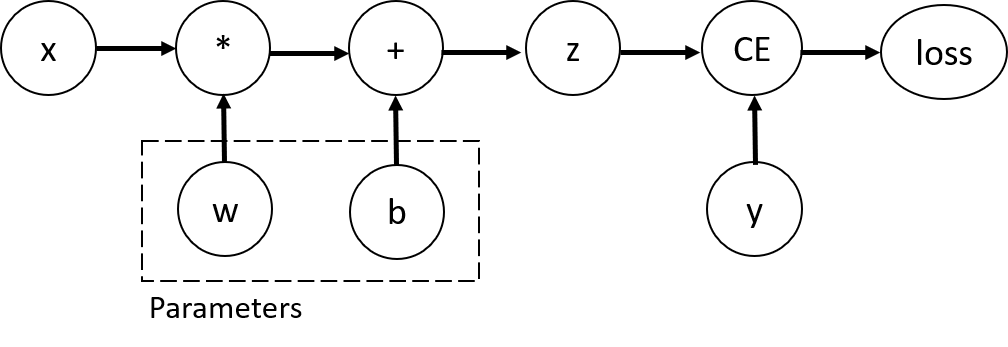

Comme nous avons spécifié `requires_grad=True` pour `w` et `b`, nous avons implicitement demandé à PyTorch de calculer les gradients par rapport à ces deux tenseurs. En d'autres termes, $w$ et $b$ sont les paramètres que nous allons optimiser par descente de gradient. Ici, il s'agit simplement de la matrice de poids et du vecteur de biais d'une transformation affine.

Les flèches dans le graphe indiquent le sens de parcours des opérations. Dans notre cas, il s'agit de la fonction *forward* c'est-à-dire de la propagation avant dans le « réseau ». Le calcul des gradients correspondant à la passe *backward*. PyTorch implémente pour chaque fonction sa version « arrière », c'est-à-dire sa fonction de gradient :

In [14]:
print(f"Fonction de gradient pour z = {z.grad_fn}")
print(f"Fonction de gradient pour `loss` = {loss.grad_fn}")

Fonction de gradient pour z = <AddBackward0 object at 0x7bd07bd63ca0>
Fonction de gradient pour `loss` = <BinaryCrossEntropyWithLogitsBackward0 object at 0x7bd07bd63eb0>


Si l'on veut optimiser les paramètres $w$ et $b$ de notre réseau de neurones simplifié, nous avons besoin de calculer les gradients de la fonction de coût (la variable `loss`) par rapport aux paramètres. Pour résumer, on a besoin de $\frac{\partial \text{loss}}{\partial w}$ et $\frac{\partial \text{loss}}{\partial b}$ pour $x$ et $y$ connus. Le calcul de ces gradients est automatique avec PyTorch : il suffit d'appeler la méthode `.backward()` sur le tenseur `loss`. Les valeurs du gradient de $w$ et $b$ sont alors stockés dans les attributs `w.grad` et `b.grad` :

In [15]:
loss.backward()
print(w.grad)
print(b.grad)

tensor([[0.3071, 0.0029, 0.0728],
        [0.3071, 0.0029, 0.0728],
        [0.3071, 0.0029, 0.0728],
        [0.3071, 0.0029, 0.0728],
        [0.3071, 0.0029, 0.0728]])
tensor([0.3071, 0.0029, 0.0728])


L'implémentation de la descente de gradient est alors très accessible : il suffit de mettre à jour $w$ et $b$ à l'aide de l'équation

$$w := w + \alpha \frac{\partial \text{loss}}{\partial w}$$

$$b := b + \alpha \frac{\partial \text{loss}}{\partial b}$$

où $\alpha$ est le *learning rate* (taux d'apprentissage) qui définit le pas de la descente de gradient.

La classe `nn.Sequential` permet de définir un réseau de neurones simple, dit *feed-forward*, dont les couches sont appliquées séquentiellement aux données d'entrée. Avec scikit-learn, nous avons implémenté un perceptron multi-couche simple. Définissons un modèle similaire en PyTorch en alternant couches linéaires (`nn.Linear`) et fonctions d'activation non-linéaires (ici, `nn.ReLU` mais d'autres activations sont implémentées dans la bibliothèque):

In [16]:
perceptron = nn.Sequential(
    nn.Linear(in_features=4, out_features=100),
    nn.ReLU(),
    nn.Linear(in_features=100, out_features=100),
    nn.ReLU(),
    nn.Linear(in_features=100, out_features=100),
    nn.ReLU(),
    nn.Linear(in_features=100, out_features=3),
)

Il s'agit d'un modèle prenant en entrée un vecteur de dimension 2 et produisant un vecteur de dimension 3 en sortie. Nous allons considérer que chaque dimension de ce vecteur de sortie est la log-probabilité de la classe associée dans le jeu de données *Iris*.

Mettons en forme le jeu de données. PyTorch utilise son propre format de tenseurs (`torch.Tensor`). Pour simplifier les choses, la classe `Dataset` est un utilitaire permettant de facilement itérer et convertir à la volée divers formats de données en tenseurs appropriés. Cette conversion se réalise aisément avec PyTorch :

In [17]:
from torch.utils.data import TensorDataset

iris_X, iris_y = datasets.load_iris(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(iris_X, iris_y, test_size=0.33, random_state=0)

X_train = torch.FloatTensor(X_train)
y_train = torch.LongTensor(y_train)

iris_dataset_train = TensorDataset(X_train, y_train)

print(iris_dataset_train[0])

(tensor([5.6000, 2.5000, 3.9000, 1.1000]), tensor(1))


PyTorch utilise la descente de gradient stochastique par *mini-batch*. La classe `DataLoader` est une abstraction qui implémente la logique de tirage aléatoire des exemples qui constituent un batch. Le *DataLoader* encapsule tout simplement le jeu de données :

In [18]:
from torch.utils.data import DataLoader

# on peut se permettre ici d'utiliser une taille de batch égale à celle du jeu de données car 
# le jeu de données est de petite taille
# l'argument shuffle=True permet de mélanger le jeu de données après chaque passe
iris_loader_train = DataLoader(iris_dataset_train, batch_size=100, shuffle=True)

Pour entraîner le modèle, PyTorch n'implémente pas d'outil très fait. Nous allons écrire nous-même la boucle d'apprentissage. Plusieurs algorithmes d'optimisation (dérivées de la descente de gradient) sont implémentés dans le sous-module `torch.optim`. Contrairement à ce que nous avons fait plus haut, nous n'allons pas utiliser L-BFGS. En pratique, on préfère des algorithmes moins gourmands en mémoire, comme la SGD (*Stochastic Gradient Descent*) ou ses variantes :

In [19]:
import torch.optim as optim

learning_rate = 1e-1
n_epochs = 1000
# on déporte les calculs sur le GPU s'il est disponible
device = "cuda" if torch.cuda.is_available() else "cpu"

# il est nécessaire de spécifier sur quels paramètres l'optimisation va porter
optimizer = optim.SGD(perceptron.parameters(), lr=learning_rate)

# on définit notre fonction de coût (ici, l'entropie croisée)
criterion = nn.CrossEntropyLoss()

# on passe le modèle en mode apprentissage
perceptron.train()
# on passe le modèle sur le CPU ou le GPU
perceptron.to(device)

from tqdm.auto import tqdm

# on boucle sur autant d'epochs que souhaité
for epoch in (pbar := tqdm(range(1, n_epochs+1))):
    # on itère une fois sur tout le jeu de données pour chaque epoch
    for data, labels in iris_loader_train:
        # Chargement des données dans la mémoire CPU ou GPU
        data = data.to(device)
        labels = labels.to(device)

        # On calcule les prédictions du modèle
        output = perceptron(data)

        # On calcule la fonction de coût (entropie croisée entre les prédictions et la vérité terrain)
        loss = criterion(output, labels)

        # Rétropropagation (gérée automatiquement par PyTorch !)
        loss.backward()

        # Un pas de descente de gradient
        optimizer.step()

        # Important: réinitialiser les gradients à zéro, sinon ils sont accumulés à chaque itération
        optimizer.zero_grad()

    pbar.set_description(f"Loss: {loss.item():.3f}")

  0%|          | 0/1000 [00:00<?, ?it/s]

Évaluons maintenant ce perceptron multi-couche sur le jeu de validation. Comme précédemment, il faut d'abord passer le jeu de données au format tensoriel de PyTorch :

In [20]:
X_test = torch.FloatTensor(X_test)
y_test = torch.LongTensor(y_test)

iris_dataset_test = TensorDataset(X_test, y_test)
iris_loader_test = DataLoader(iris_dataset_test, batch_size=100) # inutile de shuffle pour l'évaluation

On peut maintenant calculer les prédictions du modèle sur le jeu de données de test :

In [21]:
predictions = []

# on passe le modèle en mode évaluation
perceptron.eval()

# on itère une seule fois sur le jeu de test
for data, _ in iris_loader_test:
    data = data.to(device) # passage des données sur CPU ou GPU
    
    # Pas besoin de calculer les gradients, on les désactive donc pour accélérer les calculs
    with torch.no_grad():
        # inférence du modèle
        output = perceptron(data)

        # `output` contient les log-probabilités, on prend l'argmax pour obtenir la classe prédite
        preds = torch.argmax(output, dim=1)

    # On convertir les prédictions en tableau NumPy et on les concatène aux prédictions déjà obtenues
    predictions.append(preds.cpu().numpy())

predictions = np.concatenate(predictions)

On peut ensuite comparer ces prédictions avec la vérité terrain à l'aide des fonctions habituelles de scikit-learn pour calculer les métriques :

In [22]:
from sklearn.metrics import classification_report

print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       1.00      0.84      0.91        19
           2       0.83      1.00      0.91        15

    accuracy                           0.94        50
   macro avg       0.94      0.95      0.94        50
weighted avg       0.95      0.94      0.94        50



## 3. Classification des sols

Pour terminer cet atelier, manipulons des données réelles pour une tâche de classification de couverture des sols à partir d'images aériennes ou satellitaires.

### Jeu de données EuroSAT

Pour aller plus loin, nous allons nous intéresser au jeu de
données [EuroSAT](https://github.com/phelber/EuroSAT), qui est une
base d’images contenant :

- 10 classes (bâtiments industriels, bâtiments
  résidentiels, cultures saisonnières, cultures permanentes, rivières,
  lacs & mers, végétation herbacée, routes/autoroutes, pâturages et
  forêts).  
- Il y a 27000 images au total (16200 pour l'apprentissage, 5400 pour la validation et 5400 pour l'évaluation).
- Les images sont de taille $ 64\times64 $. Les images que
  nous allons utiliser sont en couleur (RGB) mais il existe une version
  multispectrale utilisant 13 longueurs d’onde différentes.  

Pour simplifier la prise en mains, nous allons la bibliothèque [`torchvision`](https://pytorch.org/vision/stable/index.html), une extension de PyTorch qui intègre de nombreux outils spécifiques pour la vision par ordinateur. En particulier, le jeu de données EuroSAT est directement intégré dans cette extension. Commençons par visualiser quelques images :

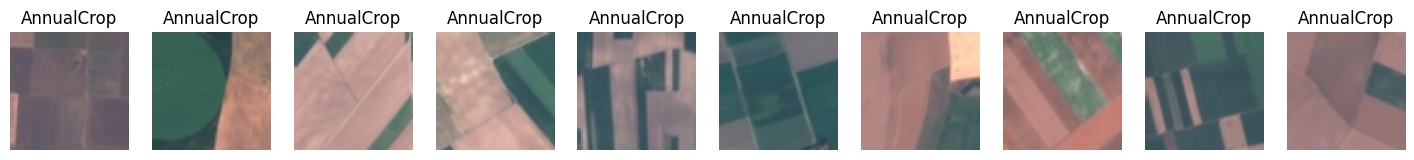

In [23]:
import matplotlib.pyplot as plt
import numpy as np

from torchvision import datasets

eurosat = datasets.EuroSAT(root="./eurosat/", download=True)

fig = plt.figure(figsize=(18, 6))
for idx, (image, label) in enumerate(eurosat):
    if idx >= 10:
        break
    fig.add_subplot(1, 10, idx+1)
    plt.imshow(image)
    plt.axis("off")
    plt.title(eurosat.classes[label])
plt.show()

Il s'agit comme indiqué précédemment d'images Sentinel-2 à 10m/px de résolution. Plus précisément, il s'agit uniquement des bandes (2, 3, 4) correspondant aux longueurs d'onde du vert, rouge et bleu dans le domaine visible. En conservant ces trois bandes, il est possible de reconstituer une image dite en « couleurs naturelles ».

Plutôt que de passer par scikit-learn pour diviser le jeu de données en apprentissage, validation et test, PyTorch implémente directement un outil similaire :

In [24]:
from torchvision.transforms import ToTensor

from torch.utils.data import random_split

# transform=ToTensor() permet de convertir les images en tenseur à la volée lors du chargement
eurosat = datasets.EuroSAT(root="./eurosat/", transform=ToTensor())

eurosat_train, eurosat_val = random_split(eurosat, lengths=[0.8, 0.2])
eurosat_train, eurosat_test = random_split(eurosat_train, lengths=[0.8, 0.2])

Comme nous allons manipuler des images, un réseau convolutif (*Convolutional Neural Network*) est plus approprié qu'un perceptron multi-couches. Nous pouvons reprendre une architecture déjà établie, par exemple celle de LeNet-5 proposée par [Yann LeCun en 1998](http://vision.stanford.edu/cs598_spring07/papers/Lecun98.pdf).

**Note**: l'architecture que nous allons utiliser ressemble à celle de LeCun mais en dévie par certains détails. Les modifications se justifient par l'avancée de l'apprentissage profond ces 25 dernières années !

In [25]:
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader

from tqdm.auto import tqdm

from torchvision.transforms import ToTensor
eurosat = datasets.EuroSAT(root="./eurosat/", transform=ToTensor(), download=True)

L'architecture LeNet-5 est assez simple. Elle comporte :

- Une couche de convolutions avec 16 filtres de taille $5\times5$ (padding de 2), suivie d’une non-linéarité $\tanh$ puis d’une couche de max pooling $2\times2$.
- Une couche de convolutions avec 32 filtres de taille $5\times5$ (padding de 2), suivie d’une non-linéarité $\tanh$ puis d’une couche de max pooling $2\times2$.
- On considère la sortie du second bloc convolutif comme un vecteur, ce que revient à « mettre à plat » les couches convolutives précédentes. Cette opération est réalisée en PyTorch à l'aide d'une « couche » virtuelle `nn.Flatten()`.
- Une couche complètement connectée de dimension 120, suivie d’une activation $\tanh$.
- Une couche complètement connectée de dimension 84, suivie d’une activation $\tanh$.
- Enfin, la couche complètement connectée qui réalise la projection vers les 10 classes du jeu de données.

In [26]:
lenet = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, padding=2),
    nn.Tanh(),
    nn.MaxPool2d(kernel_size=2),
    nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, padding=2),
    nn.Tanh(),
    nn.MaxPool2d(kernel_size=2),
    nn.Flatten(),
    torch.nn.Linear(16*16*16, 120),
    torch.nn.Tanh(),
    torch.nn.Linear(120, 84),
    torch.nn.Tanh(),
    torch.nn.Linear(84, 10),
)

Comme pour le perceptron, nous allons implémenter notre propre boucle d'apprentissage sur EuroSAT afin d'entraîner le modèle. Nous pouvons ajouter quelques fioritures supplémentaires, notamment :
- le calcul de l'erreur moyenne à chaque epoch d'apprentissage,
- le calcul des métriques (erreur et *accuracy*) sur le jeu de validation à la fin de chaque epoch, afin de mesurer la progression du modèle,
- le stockage de ces métriques pour tracer les courbes à la fin de l'entraînement.

In [27]:
learning_rate = 1e-3
momentum = 0.9
n_epochs = 50
batch_size = 512
device = "cuda"

train_dataloader = DataLoader(eurosat_train, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(eurosat_val, batch_size=batch_size)
optimizer = optim.Adam(lenet.parameters(), lr=learning_rate)

criterion = nn.CrossEntropyLoss()

lenet.train()
lenet.to(device)

train_loss, val_loss = (0., 0.)
train_losses, val_losses = [], []
accuracies = []

# on boucle sur autant d'epochs que souhaité
for epoch in (pbar := tqdm(range(1, n_epochs+1))):
    # on itère une fois sur tout le jeu de données pour chaque epoch
    for data, labels in train_dataloader:
        # Chargement des données dans la mémoire CPU ou GPU
        data, labels = data.to(device), labels.to(device)
        # On calcule les prédictions du modèle
        output = lenet(data)
        # On calcule la fonction de coût (entropie croisée entre les prédictions et la vérité terrain)
        loss = criterion(output, labels)
        # Rétropropagation (gérée automatiquement par PyTorch !)
        loss.backward()
        # Un pas de descente de gradient
        optimizer.step()
        # Important: réinitialiser les gradients à zéro, sinon ils sont accumulés à chaque itération
        optimizer.zero_grad()

        # On calcule l'erreur d'apprentissage moyenne
        train_loss += loss.item()

    # À la fin de chaque epoch, on évalue le modèle sur le jeu de *validation*
    with torch.no_grad():
        predictions = []
        ground_truth = []
        for data, labels in val_dataloader:
            data, labels = data.to(device), labels.to(device)
            output = lenet(data)
            loss = criterion(output, labels)
            # Calcul de l'erreur moyenne en validation
            val_loss += loss.item()

            preds = torch.argmax(output, dim=1)
            predictions.append(preds.cpu().numpy())
            ground_truth.append(labels.cpu().numpy())
        # Calcul de l'accuracy
        accuracy = sklearn.metrics.accuracy_score(np.concatenate(ground_truth), np.concatenate(predictions))
        accuracies.append(accuracy)
            

    train_loss, val_loss = train_loss / len(train_dataloader), val_loss / len(val_dataloader)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    pbar.set_description(f"Train loss: {train_loss:.3f}, validation loss: {val_loss:.3f}, val accuracy: {accuracy*100:.2f} (epoch {epoch}/{n_epochs})")

  0%|          | 0/50 [00:00<?, ?it/s]

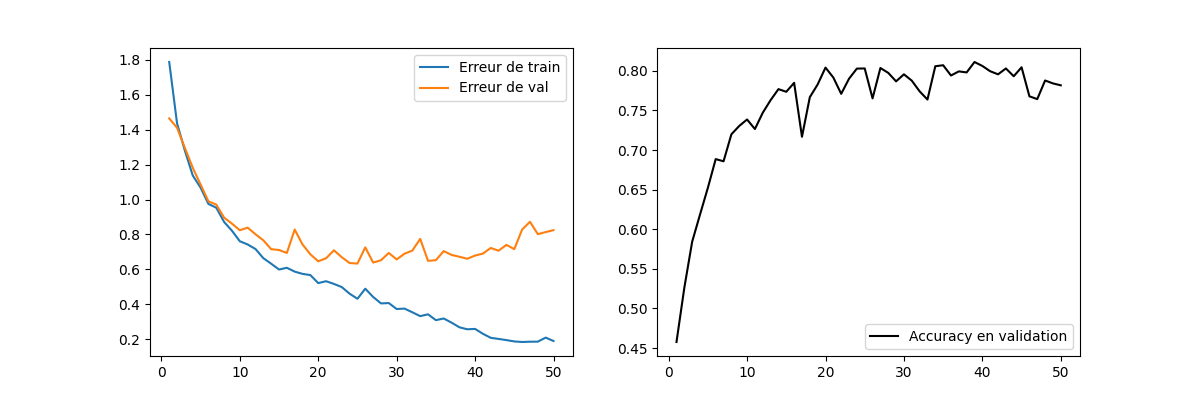

In [28]:
%matplotlib widget
fig = plt.figure(figsize=(12, 4))
fig.add_subplot(121)
plt.plot(range(1, n_epochs+1), train_losses, label="Erreur de train")
plt.plot(range(1, n_epochs+1), val_losses, label="Erreur de val")
plt.legend()

fig.add_subplot(122)
plt.plot(range(1, n_epochs+1), accuracies, 'k', label="Accuracy en validation")
plt.legend()
plt.show()

On peut constater une forme de sur-apprentissage sur les courbes. En effet, même si l'erreur d'apprentissage diminue, l'erreur de validation elle stagne, voire augmente ! Autrement dit, le modèle mémorise les exemples du jeu d'apprentissage mais ne généralise pas aussi bien aux exemples du jeu de validation. Cela se voit sur la courbe des scores, qui stagne autour de 80% après quelques dizaines d'epochs.

En pratique, observer ces métriques permet de sélectionner le modèle qui généralisera le mieux, c'est-à-dire celui qui a les meilleures performances **sur le jeu de validation**.

Une fois ce travail fait, on peut évaluer le modèle sur le jeu de test pour obtenir une estimation de ses performances en production :

In [29]:
lenet.eval() # modèle en mode inférence

test_dataloader = DataLoader(eurosat_test, batch_size=batch_size)


with torch.no_grad():
    predictions = []
    ground_truth = []
    for data, labels in test_dataloader:
        data, labels = data.to(device), labels.to(device)
        output = lenet(data)
        loss = criterion(output, labels)

        preds = torch.argmax(output, dim=1)
        predictions.append(preds.cpu().numpy())
        ground_truth.append(labels.cpu().numpy())

predictions = np.concatenate(predictions)
ground_truth = np.concatenate(ground_truth)

print(classification_report(ground_truth, predictions, target_names=eurosat.classes))

                      precision    recall  f1-score   support

          AnnualCrop       0.71      0.87      0.78       516
              Forest       0.93      0.90      0.92       473
HerbaceousVegetation       0.74      0.63      0.68       465
             Highway       0.55      0.59      0.57       378
          Industrial       0.91      0.90      0.91       434
             Pasture       0.79      0.72      0.75       314
       PermanentCrop       0.65      0.64      0.64       411
         Residential       0.94      0.87      0.90       468
               River       0.68      0.65      0.67       403
             SeaLake       0.91      0.95      0.93       458

            accuracy                           0.78      4320
           macro avg       0.78      0.77      0.77      4320
        weighted avg       0.79      0.78      0.78      4320



### Fine-tuning

Une pratique courante en *deep learning* est de spécialiser des réseaux profonds existants sur des tâches particulières. C'est notamment utile lorsque l'on a peu de données annotées disponible pour construire un jeu d'entraînement. En reconnaissance d'objets, il est ainsi courant de repartir d'un modèle pré-entraîné sur ImageNet. ImageNet est une base de données de plus d'1 million d'images catégorisées dans 1000 classes différentes. Les modèles entraînés sur ImageNet sont donc très performants pour reconnaître de nombreux objets du quotidien (téléphone, voiture, animaux, personnes, etc.). On ne peut bien sûr pas les utiliser tels quels pour la classification des sols. Cependant, on peut repartir d'un tel réseau de neurones et optimiser tout ou partie de ses paramètres pour la tâche qui nous intéresse. C'est ce que l'on appelle le *fine-tuning*. C'est un cas particulier de l'apprentissage par transfert de connaissances : on adapte un modèle existant en transférant ses « connaissances » sur une nouvelle tâche.

La bibliothèque *torchvision* contient de nombreux modèles préentraînés. Prenons le modèle MobileNet v3. Son principal intérêt est d'être pré-entraîné sur ImageNet et d'avoir une architecture efficace optimisée pour réduire les temps de calcul.

In [30]:
import torch
import torchvision
from torchvision.models import mobilenet_v3_large
from torchvision.models.mobilenetv3 import MobileNet_V3_Large_Weights

net = mobilenet_v3_large(weights=MobileNet_V3_Large_Weights.DEFAULT)
print(net)

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

On peut remarquer que le dernier bloc (`classifier`) consiste en deux couches entièrement connectées (`nn.Linear`) qui prennent les caractéristiques extraites par la première partie du réseau et les projettent dans un espace à 1000 dimensions. C'est ce qui est attendu puisque le modèle est initialement entraîné pour catégoriser les images parmi les 1000 classes possibles d'ImageNet. Nous allons remplacer ces couches par notre propre classifieur à 10 classes d'intérêt :

In [31]:
import torch.nn as nn

net.classifier[-1] = nn.Linear(in_features=1280, out_features=10)

classifier = net.classifier

Comme précédemment, nous allons entraîner ce modèle. Toutefois dans le cas du fine-tuning, il est souvent possible de ne spécialiser qu'une partie du réseau, en l'occurrence le classifieur que nous venons de modifier. Le reste du modèle, qui apprend les représentations « profondes » des images peut être laissé à l'identique, sans ré-entraînement. Après tout, cette partie du réseau a été entraîné sur des millions d'image, on peut donc supposer que les représentations apprises sont déjà suffisamment discriminantes pour reconnaître les classes qui nous intéressent. Nous allons donc calculer les gradients et réaliser l'optimisation seulement pour les couches du classifieur (`net.classifier`):

In [32]:
# on désactive le calcul du gradient pour toutes les couches
for param in net.parameters():
    param.requires_grad = False

# ... sauf pour celles du classifieur
for param in classifier.parameters():
    param.requires_grad = True

Le reste est identique à d'habitude, à l'exception que l'optimiseur ne porte que sur les paramètres du classifieur, et non les paramètres du modèle entier :

In [36]:
learning_rate = 5e-4
momentum = 0.9
n_epochs = 10
batch_size = 512
device = "cuda"

from torch.utils.data import DataLoader
train_dataloader = DataLoader(eurosat_train, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(eurosat_val, batch_size=batch_size)

import torch.optim as optim
optimizer = optim.Adam(classifier.parameters(), lr=learning_rate, weight_decay=1e-3)

criterion = nn.CrossEntropyLoss()

net.train()
net.to(device)

train_loss, val_loss = (0., 0.)
train_losses, val_losses = [], []
accuracies = []

from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score

# on boucle sur autant d'epochs que souhaité
for epoch in (pbar := tqdm(range(1, n_epochs+1))):
    # on itère une fois sur tout le jeu de données pour chaque epoch
    for data, labels in train_dataloader:
        # Chargement des données dans la mémoire CPU ou GPU
        data, labels = data.to(device), labels.to(device)
        # On calcule les prédictions du modèle
        output = net(data)
        # On calcule la fonction de coût (entropie croisée entre les prédictions et la vérité terrain)
        loss = criterion(output, labels)
        # Rétropropagation (gérée automatiquement par PyTorch !)
        loss.backward()
        # Un pas de descente de gradient
        optimizer.step()
        # Important: réinitialiser les gradients à zéro, sinon ils sont accumulés à chaque itération
        optimizer.zero_grad()

        # On calcule l'erreur d'apprentissage moyenne
        train_loss += loss.item()

    # À la fin de chaque epoch, on évalue le modèle sur le jeu de *validation*
    with torch.no_grad():
        predictions = []
        ground_truth = []
        for data, labels in val_dataloader:
            data, labels = data.to(device), labels.to(device)
            output = net(data)
            loss = criterion(output, labels)
            # Calcul de l'erreur moyenne en validation
            val_loss += loss.item()

            preds = torch.argmax(output, dim=1)
            predictions.append(preds.cpu().numpy())
            ground_truth.append(labels.cpu().numpy())
        # Calcul de l'accuracy
        accuracy = accuracy_score(np.concatenate(ground_truth), np.concatenate(predictions))
        accuracies.append(accuracy)

    train_loss, val_loss = train_loss / len(train_dataloader), val_loss / len(val_dataloader)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    pbar.set_description(f"Train loss: {train_loss:.3f}, validation loss: {val_loss:.3f}, val accuracy: {accuracy*100:.2f} (epoch {epoch}/{n_epochs})")

  0%|          | 0/10 [00:00<?, ?it/s]

L'affichage des courbes permet de constater un comportement légèrement différent de celui observé avec le modèle LeNet-5 :

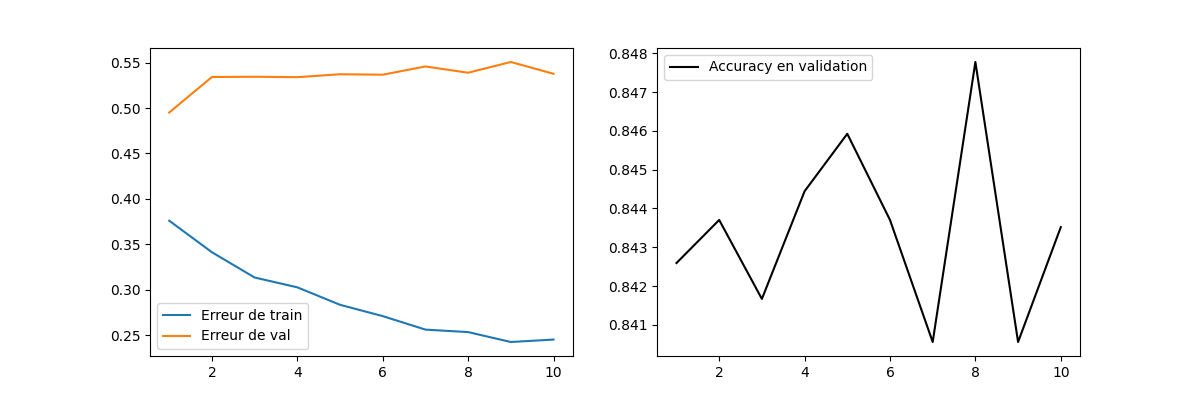

In [37]:
fig = plt.figure(figsize=(12, 4))
fig.add_subplot(121)
plt.plot(range(1, n_epochs+1), train_losses, label="Erreur de train")
plt.plot(range(1, n_epochs+1), val_losses, label="Erreur de val")
plt.legend()

fig.add_subplot(122)
plt.plot(range(1, n_epochs+1), accuracies, 'k', label="Accuracy en validation")
plt.legend()
plt.show()

On peut constater que l'apprentissage par transfert est nettement plus rapide : en seulement quelques epochs, MobileNet v3 pré-entraîné devient meilleur que LeNet-5 entraîné pendant plusieurs dizaines d'epochs.

In [38]:
test_dataloader = DataLoader(eurosat_test, batch_size=batch_size)

with torch.no_grad():
    predictions = []
    ground_truth = []
    for data, labels in test_dataloader:
        data, labels = data.to(device), labels.to(device)
        output = net(data)
        loss = criterion(output, labels)

        preds = torch.argmax(output, dim=1)
        predictions.append(preds.cpu().numpy())
        ground_truth.append(labels.cpu().numpy())

predictions = np.concatenate(predictions)
ground_truth = np.concatenate(ground_truth)

print(classification_report(ground_truth, predictions, target_names=eurosat.classes))

                      precision    recall  f1-score   support

          AnnualCrop       0.86      0.84      0.85       516
              Forest       0.89      0.89      0.89       473
HerbaceousVegetation       0.73      0.83      0.78       465
             Highway       0.73      0.71      0.72       378
          Industrial       0.89      0.83      0.86       434
             Pasture       0.81      0.76      0.78       314
       PermanentCrop       0.76      0.74      0.75       411
         Residential       0.89      0.90      0.89       468
               River       0.73      0.72      0.73       403
             SeaLake       0.91      0.93      0.92       458

            accuracy                           0.82      4320
           macro avg       0.82      0.82      0.82      4320
        weighted avg       0.82      0.82      0.82      4320



Il peut être intéressant de comparer les performances de ce modèle *fine-tuned* avec par exemple la même architecture MobileNet v3 mais sans le pré-entraînement. On parle alors de modèle entraîné *from scratch*, c'est-à-dire à partir d'une initialisation aléatoire. Il suffit de modifier les cellules idoines en retirant l'argument `weights=...` de l'initialisation du modèle, puis en commentant la ligne `param.requires_grad = False` et en exécutant les cellules qui suivent.

Pour aller plus loin, il serait nécessaire :
- de comparer différents architectures de modèles, par exemple des réseaux de neurones classiques de l'état de l'art tels que les ResNet ou Swin.
- d'évaluer le gain obtenu en utilisant toutes les bandes multispectrales. En effet, jusqu'ici nous n'avons utilisé que les bandes RGB, dans le spectre visible. Or, on sait que certaines parties du spectres, notamment dans l'infrarouge, permettent de mieux caractériser la végétation.

À titre d'information, les meilleurs modèles de l'état de l'art atteignent des scores supérieurs à 99% de bonne classification sur EuroSAT. Un benchmark indicatif est disponible [en ligne](https://paperswithcode.com/sota/image-classification-on-eurosat) si vous vous sentez l'âme compétitive.